In [2]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
import numpy as np
from typing import Tuple

<figure id="figure-5">
<div style="background-color: white">

![](figures/dwt.svg)
</div>

<figcaption style="text-align: center">

Figure 5: An $L$ level binary discrete wavelet transform.</figcaption></figure>

# 9 The Discrete Wavelet Transform (DWT)

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

The final method of energy compaction that we shall investigate, is the
discrete wavelet transform. In some ways this attempts to combine the best features of
the Laplacian pyramid and the DCT:

* Like the pyramid, the DWT analyses the image at a range of different
  scales (levels) and employs symmetrical filters;

* Like the DCT, the DWT avoids any expansion in the number of coefficients.

Wavelet theory was evolved by mathematicians during the 1980's. As with the LBT, we shall not attempt to teach this theory here, just illustrate a relatively simple form of it.

Wavelets are short waveforms which are usually the impulse responses of
filters.  Wavelet transforms employ banks of bandpass filters, whose impulse
responses are scaled versions of each other, in
order to get pass-bands in different parts of the frequency spectrum.  If the
impulse response of a filter is scaled in time by a factor $a$, then the
filter frequency response is scaled by the factor $1/a$.  Typically $a = 2$
from one filter to the next, and each bandpass filter is designed to pass a
2:1 range of frequencies (one octave). We can split an image up using wavelets by a process known as a _binary wavelet tree_.

## 9.1 The binary wavelet tree


We start in 1-D with the
simplest possible pair of filters, operating on just two input samples, $x_n$
and $x_{n-1}$.  The two filter outputs, $u_n$ and $v_n$ at time $n$ are
given by:
$$
 u_n = \tfrac{1}{2} (x_n + x_{n-1}) \quad \text{and} \quad
 v_n = \tfrac{1}{2} (x_n - x_{n-1})
$$

The first filter averages adjacent samples, and so rejects the higher
frequency components of $x$, while the second filter differences these
samples, and so rejects the lower frequency components.  These filters are
known as the _analysis_ filter pair, $H_1(z) = \tfrac{1}{2} (1 + z^{-1})$
and $H_2(z) = \tfrac{1}{2} (1 - z^{-1})$.  It is clear that we can recover the
two input samples from the filter outputs using:
$$
 x_n = u_n + v_n \quad \text{and} \quad x_{n-1} = u_n - v_n
$$

Next it is important to note that we need only retain the samples of $u_n$
and $v_n$ at even values of $n$ in order to be able to recover all the
original samples of $x$.  Hence $u$ and $v$ may be decimated 2:1 and still
allow perfect reconstruction of $x$.  If $x$ is a finite length vector (e.g. a
row of image pixels), then $u$ and $v$ are each half as long as $x$, so the
total number of samples is preserved by the transformation.

A wavelet binary tree may be constructed using these filters, by using an
identical pair, $H_1$ and $H_2$, to filter the decimated lowpass signal
$u_{2n}$, to give a pair of outputs, $uu_{2n}$ and $uv_{2n}$, representing
the lower and upper halves of the first low band.  These may again be
decimated 2:1 and still permit perfect reconstruction of $u$.  This process
may be continued as often as desired: each time splitting the lowest band in
two, and decimating the sample rate of the filter outputs by 2:1.  At each
stage the bandwidth of the two lowest filters is halved, and their impulse
responses are doubled in length.  The total number of output samples remains
constant, however many stages are used.

For example, if $f_s$ is the input sample rate, a 3-stage binary tree will
split the input signal bandwidth of 0 to $f_s/2$ into the following four
bands:
$$
0 \rightarrow f_s/16; \ \ f_s/16 \rightarrow f_s/8; \ \ f_s/8 \rightarrow
f_s/4;  \ \ f_s/4 \rightarrow f_s/2.
$$

The very simple filters, given above, do not generate a filter tree with
good characteristics, since the wavelets turn out to be just a pair of
square pulses.  These generate _blocking_ artefacts when used for image
compression (in fact they are equivalent to the 2 point ($N=2$)
DCT). A better set of filters are the LeGall 5 and 3 tap pair,
given by:
$$
 u_n = \tfrac{1}{8} (-x_{n+2} + 2 x_{n+1} + 6 x_n + 2 x_{n-1} - x_{n-2})
  \quad \text{ and }  \quad
 v_{n+1} = \tfrac{1}{4} (-x_{n+2} + 2 x_{n+1} - x_n)
$$

If $u$ and $v$ are decimated by 2 by choosing even $n$ only, the lowband outputs
$u_n$ are centred on the even samples, and the highband outputs $v_{n+1}$ are
centred on the odd samples.  This is very important to allow perfect
reconstruction of $x$ from $u$ and $v$.

The equations for reconstruction may be obtained by solving the above to get:

\begin{align}
 x_n &= \tfrac{1}{2} (-v_{n+1} + 2 u_n - v_{n-1}) \quad \text{and}  \\
 x_{n+1} &= \tfrac{1}{2} (x_{n+2} + 4 v_{n+1} + x_n) =
 \tfrac{1}{4} (-v_{n+3} + 2 u_{n+2} + 6 v_{n+1} + 2 u_n - v_{n-1})
\end{align}

In general, most analysis filters will not yield such simple reconstruction
solutions, and the design of suitable filters is a non-trivial topic that we
shall not cover here.


# 9.2 Applying the DWT to images


As with the DCT, the 2-D DWT may be obtained by applying a 1-D transform to
first the rows and then the columns of an image.

Start by loading the Lighthouse image and defining the two LeGall
filters given above:

In [3]:
X, _ = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
h1 = np.array([-1, 2, 6, 2, -1])/8
h2 = np.array([-1, 2, -1])/4

We can use the function `rowdec` from the pyramid work, to
produce a decimated and lowpass filtered version of the rows of
`X` (remembering to subtract 128 as before) using:

In [4]:
from cued_sf2_lab.laplacian_pyramid import rowdec
U = rowdec(X, h1)

To get the high-pass image `V`, it is important to align the decimated
samples with the odd columns of `X` (assuming the first column is $n = 0$)
whereas `U` is aligned with the even columns.  To do this we use a
slightly modified version of `rowdec`, called `rowdec2`.

In [5]:
from cued_sf2_lab.laplacian_pyramid import rowdec2
V = rowdec2(X, h2)

<div class="alert alert-block alert-danger">

Display `U` and `V` to see the outputs of the first filter pair
and comment on their relative energies (or standard deviations). Note that `U` and `V` are half the width of `X`, but that `U` is otherwise similar to `X`.</div>

Relative energies: 23.5046142865414 (energy of U / energy of V)
Relative standard deviations: 4.827332954303659 (std dev of U / std dev of V)
U has much more energy than V. Most of the energy, as usual, is in the low frequency range.


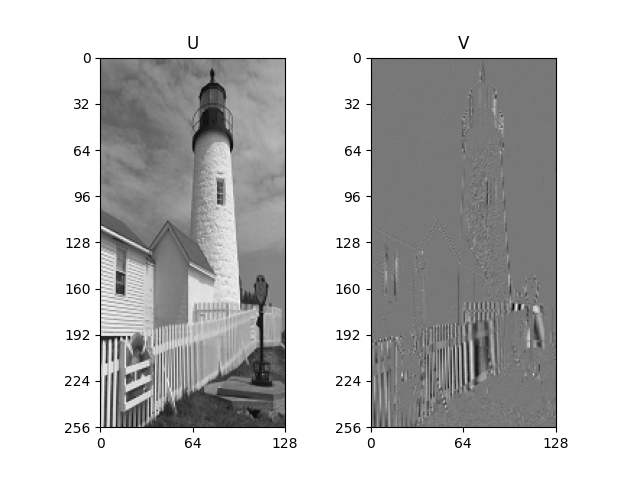

In [6]:
# your code here
fig, axs = plt.subplots(1,2)
plot_image(U, ax=axs[0])
plot_image(V, ax=axs[1])
axs[0].set_title("U")
axs[1].set_title("V");

relative_energies = np.sum(U**2.0)/np.sum(V**2.0)
relative_stddevs = np.std(U)/np.std(V)
print("Relative energies:", relative_energies, "(energy of U / energy of V)")
print("Relative standard deviations:", relative_stddevs, "(std dev of U / std dev of V)")
print("U has much more energy than V. Most of the energy, as usual, is in the low frequency range.")

Now filter the columns of `U` and `V` using `rowdec
/ rowdec2` with the transpose operator:

In [7]:
UU = rowdec(U.T, h1).T
UV = rowdec2(U.T, h2).T
VU = rowdec(V.T, h1).T
VV = rowdec2(V.T, h2).T

<div class="alert alert-block alert-danger">
    
Display `np.block([[UU, VU], [UV, VV]])`, and comment
on what sort of edges or features are selected by each filter. You may need to multiply the high-pass images by a factor $k > 1$ to display them clearly. Why is this?</div>

Block UU selects low-pass.
Block VU selects edges of lighthouse and fence - VERTICAL EDGES.
Block UV selects edges of the other houses in the image - HORIZONTAL EDGES.
Block VV selects highest frequency components (border between very light and very dark???).

May need to multiply high-pass images by factor k > 1 to display them clearly because 
they have lower bandwidth than low-pass image so are displayed by colour map using a narrower 
range of grey values. Multiplying by k increases their (relative) bandwidth ==> greater range of 
colours with which to display the image ==> greater visual contrast ==> can see images more clearly.


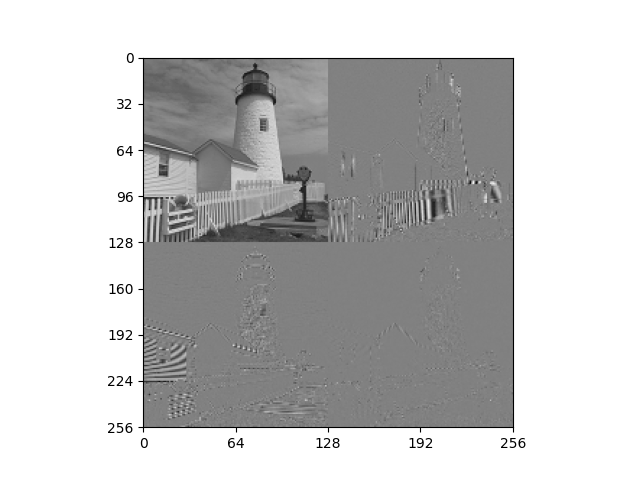

In [8]:
# your code here
fig, ax = plt.subplots()
plot_image(np.block([[UU, VU*2], [UV*2, VV*2]]));
print("Block UU selects low-pass.")
print("Block VU selects edges of lighthouse and fence - VERTICAL EDGES.")
print("Block UV selects edges of the other houses in the image - HORIZONTAL EDGES.")
print("Block VV selects highest frequency components (border between very light and very dark???).")

print("\nMay need to multiply high-pass images by factor k > 1 to display them clearly because \n\
they have lower bandwidth than low-pass image so are displayed by colour map using a narrower \n\
range of grey values. Multiplying by k increases their (relative) bandwidth ==> greater range of \n\
colours with which to display the image ==> greater visual contrast ==> can see images more clearly.")

Alternatively, plot the images separately (without using np.block) to avoid this need...


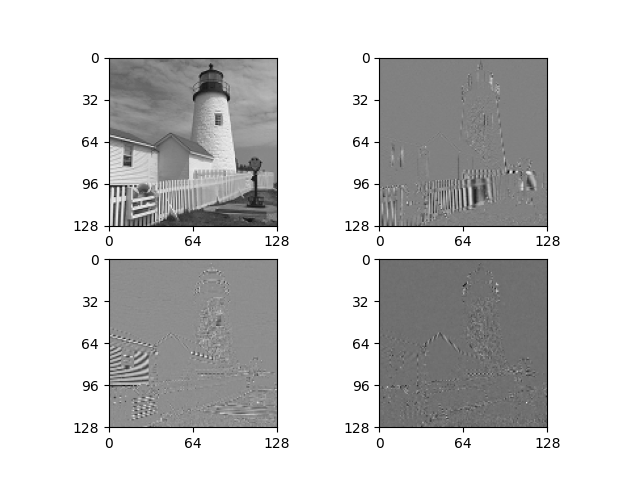

In [9]:
print("Alternatively, plot the images separately (without using np.block) to avoid this need...")
fig, ax = plt.subplots(2,2)
plot_image(UU, ax=ax[0,0])
plot_image(VU, ax=ax[0,1])
plot_image(UV, ax=ax[1,0])
plot_image(VV, ax=ax[1,1]);

We must now check that it is possible to recover the image from
these sub-images, using reconstruction filters, `g1` and `g2`, and the functions, `rowint` and `rowint` (which
is modified in a similar way to `rowdec2` to allow correct
alignment of the high-pass samples). To reconstruct `Ur` and
`Vr` from `UU`, `UV`, `VU` and `VV` use:

In [10]:
from cued_sf2_lab.laplacian_pyramid import rowint, rowint2

g1 = np.array([1, 2, 1])/2
g2 = np.array([-1, -2, 6, -2, -1])/4
Ur = rowint(UU.T, g1).T + rowint2(UV.T, g2).T
Vr = rowint(VU.T, g1).T + rowint2(VV.T, g2).T

In [11]:
# 9.1 eqn (2) there is a mistake? should be -2 instead of +2 in the filter?

Note the gain of 2 in the reconstruction filters, `g1` and
`g2` (to compensate for losing half the samples in the
decimation / interpolation processes).   These filters are also
not quite the same as those that might be inferred from the
equations for $x_n$ and $x_{n+1}$ on the previous page.  This is
because `g1` defines how {\it only} the $u$ samples contribute
both to the even and odd samples of $x$, while `g2` defines
how the $v$ samples contribute.

Check that `Ur` and `Vr` are the same as `U` and
`V`, and then reconstruct `Xr` from these:

In [12]:
# your code here to check Ur and Vr
print(np.max(np.abs(Ur-U)))
print(np.max(np.abs(Vr-V)))

0.0
0.0


In [13]:
# demonstrator answer here
np.testing.assert_equal(Ur, U)
np.testing.assert_equal(Vr, V)

In [14]:
Xr = rowint(Ur,g1) + rowint2(Vr,g2)

Check that `Xr` is the same as `X`.

In [15]:
# your code here
print(np.max(np.abs(Xr-X)))

0.0


The above operations are a bit tedious to repeat if we want to
apply the DWT recursively to obtain several levels of filtering,
so we have written a pair of functions, `dwt` and `idwt`, to perform the 2-D analysis and reconstruction
operations. Examine these to see that they perform the same
operations as above, except that the transformed sub-images are
stored as parts of a single matrix, the same size as `X`,
rather than as separate matrices.

In [16]:
from cued_sf2_lab.dwt import dwt
IPython.display.Code(inspect.getsource(dwt), language="python")

def dwt(X: np.ndarray, h1: np.ndarray = h1, h2: np.ndarray = h2) -> np.ndarray:
    """
    Return a 1-level 2-D discrete wavelet transform of X.

    Default h1 and h2 are the LeGall filter pair.

    Parameters:
        X: Image matrix (Usually 256x256)
        h1, h2: Filter coefficients
    Returns:
        Y: 1-level 2D DWT of X
    """
    m, n = X.shape
    if m % 2 or n % 2:
        raise ValueError("Image dimensions must be even")
    Y = np.concatenate([rowdec(X, h1), rowdec2(X, h2)], axis=1)
    Y = np.concatenate([rowdec(Y.T, h1).T, rowdec2(Y.T, h2).T], axis=0)
    return Y

In [17]:
from cued_sf2_lab.dwt import idwt
IPython.display.Code(inspect.getsource(idwt), language="python")

def idwt(X: np.ndarray, g1: np.ndarray = g1, g2: np.ndarray = g2)-> np.ndarray:
    """
    Return a 1-level 2-D inverse discrete wavelet transform on X.

    If filters G1 and G2 are given, then they are used, otherwise the LeGall
    filter pair are used.
    """
    m, n = X.shape
    if m % 2 or n % 2:
        raise ValueError("Image dimensions must be even")
    m2 = m//2
    n2 = n//2
    Y = rowint(X[:m2, :].T, g1).T + rowint2(X[m2:, :].T,g2).T;
    Y = rowint(Y[:, :n2], g1) + rowint2(Y[:, n2:], g2)
    return Y

You can check their operation as below::

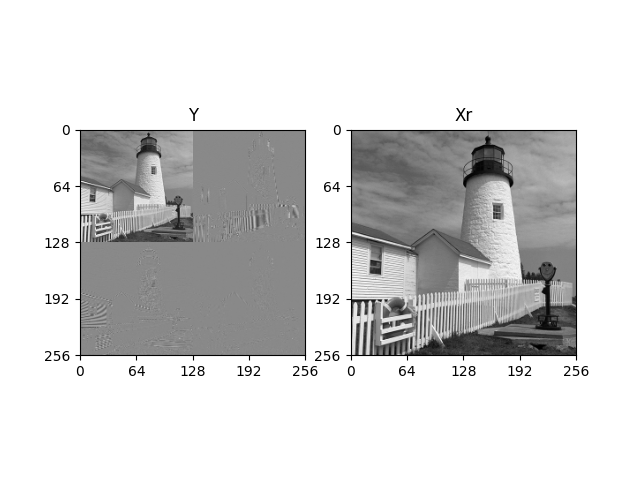

In [18]:
Y = dwt(X)
Xr = idwt(Y)

fig, axs = plt.subplots(1, 2)
plot_image(Y, ax=axs[0])
axs[0].set(title="Y")
plot_image(Xr, ax=axs[1])
axs[1].set(title="Xr");

`Y` should be the same as the composite `[UU VU; UV VV]` image that
you displayed earlier, and `Xr` should be the same as `X`.

Now implement a multilevel DWT by first applying `dwt` to
`X` using:

```python
m=256
Y=dwt(X)
plot_image(Y, ax=some_axis)
```

and then iteratively apply `dwt` to the top left sub-image
of `Y` by repeating:
```python
m = m//2
Y[:m,:m] = dwt(Y[:m,:m])
plot_image(Y, ax=some_axis)
```

In [19]:
# your code here
def multilevelDWT(image, numlevels, plot_stages=False):
    """Implement a multilevel DWT, returning the final compressed image
    and optionally plotting images at each of the progressive dwt levels.
    """
    m=256
    Y=dwt(image)
    if plot_stages:
        fig, ax = plt.subplots()
        plot_image(Y, ax=ax)
        ax.set_title("1-level dwt");

    for i in range(numlevels - 1):
        m = m//2
        Y[:m,:m] = dwt(Y[:m,:m])
        if plot_stages:
            fig, ax = plt.subplots()
            plot_image(Y, ax=ax)
            ax.set_title(f"{i+2}-level dwt");
    return Y

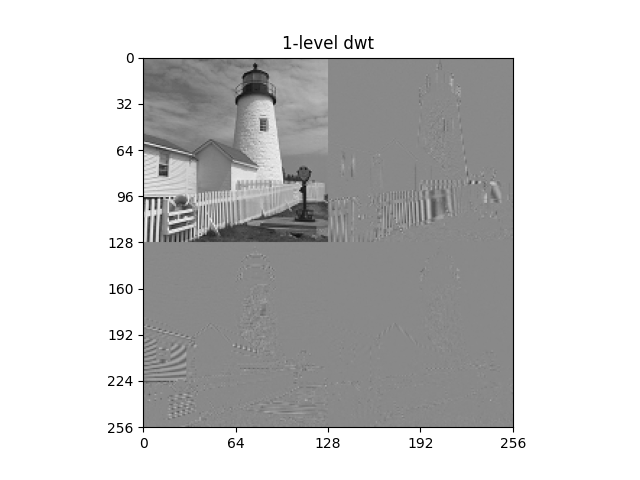

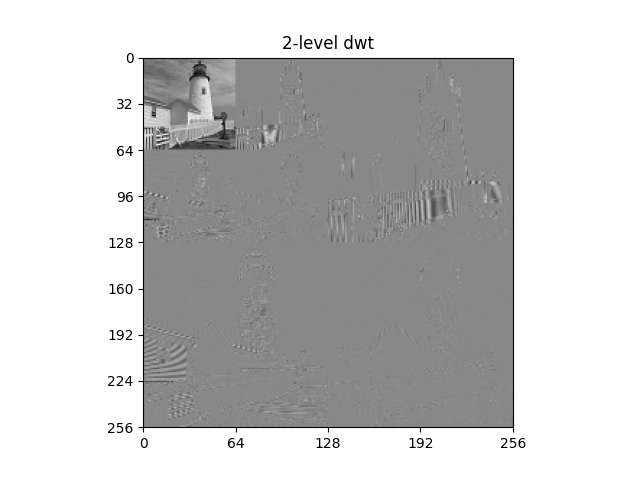

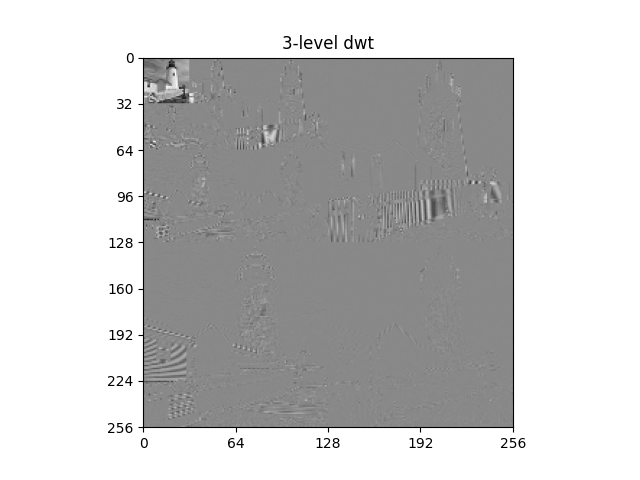

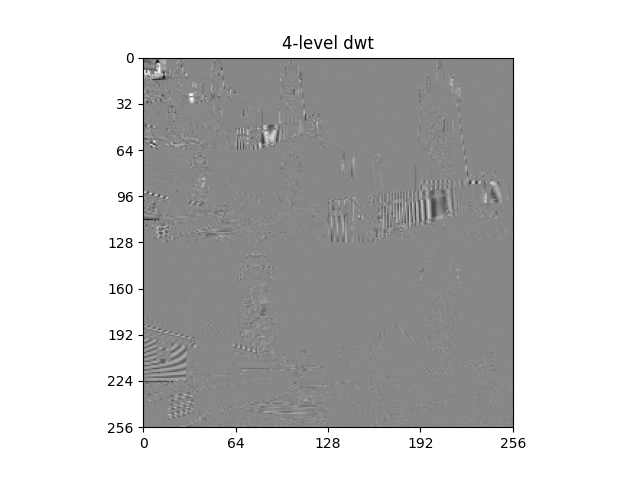

In [20]:
Y = multilevelDWT(X, 4, plot_stages=True)

We now have the image split using a binary wavelet tree (stricly a
quaternary tree in 2-D).  Write
similar iterative code to that given above, which can reconstruct
the image from the final set of `Y` sub-images after a 4-level
wavelet transform. Check that your reconstructed image is the
same as `X`.

In [21]:
# your code here
def reconstructMultilevelDWT(image, numlevels):
    n = int(256/(2**(numlevels-1)))
    Xr = image.copy()
    for i in range(numlevels):
        Xr[:n,:n] = idwt(Xr[:n,:n])
        n *= 2
    return Xr

difference between reconstruced image and X = 0.0


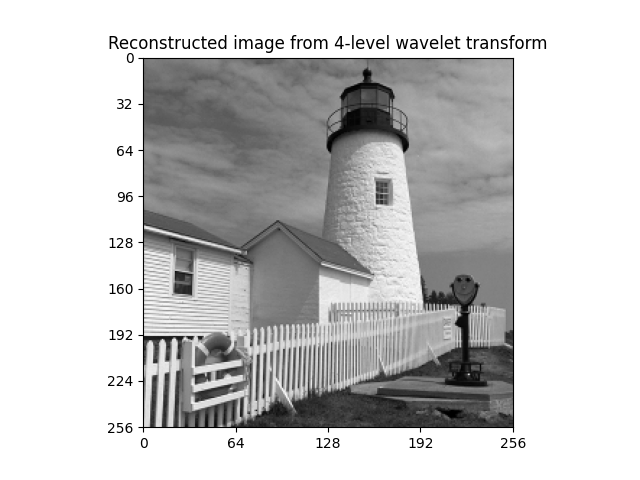

In [22]:
Y = multilevelDWT(X, 4, plot_stages=False)
Xr = reconstructMultilevelDWT(Y, 4)
fig, ax = plt.subplots()
plot_image(Xr)
ax.set_title("Reconstructed image from 4-level wavelet transform")
print("difference between reconstruced image and X =", np.max(np.abs(Xr - X)))

## 9.3 Quantisation and coding efficiency

First rewrite the sequences of operations required to perform
$n$ levels of DWT and inverse DWT as two separate M-files, `nlevdwt` and `nlevidwt`. `nlevdwt` should transform
`X` into `Y`, and `nlevidwt` should inverse
transform a quantised set of sub-images `Yq` into the
reconstructed image `Z`.  Check your functions by ensuring
that `Z` is the same as `X` if `Yq = Y`.

In [23]:
def nlevdwt(X, n):
    # your code here
    m = X.shape[0]*2
    Y = X.copy()
    for _ in range(n):
        m = m//2
        Y[:m,:m] = dwt(Y[:m,:m])
    return Y

def nlevidwt(Y, n):
    # your code here
    m = int(256/(2**(n-1)))
    Z = Y.copy()
    for i in range(n):
        Z[:m,:m] = idwt(Z[:m,:m])
        m *= 2
    return Z

In [24]:
# your code here to test `nlevdwt` and `nlevidwt`
for n in range(1,5):
    Y = nlevdwt(X, n)
    Z = nlevidwt(Y, n)
    print(f"Difference between Z and X for {n}-level unquantised DWT =", np.max(np.abs(Z - X)))

Difference between Z and X for 1-level unquantised DWT = 0.0
Difference between Z and X for 2-level unquantised DWT = 0.0
Difference between Z and X for 3-level unquantised DWT = 0.0
Difference between Z and X for 4-level unquantised DWT = 0.0


Now design a function, `quantdwt`, which will quantise the
sub-images of `Y` to give `Yq` and calculate their
entropy.  The sub-images at each level `i` of the DWT should
be quantised according to a $3 \times (n+1)$ matrix `dwtstep[k,i]` of
step-sizes, where $\mathtt{k}=\left\{0,1,2\right\}$ corresponds to each of the three high-pass images at level `i` (top right, bottom left, and bottom right, respectively), and the final low-pass image is quantised with `dwtstep[0,n]`. This matrix will be populated either with the same number in all elements (for equal-step-size quantisation) or a range of different numbers (for equal-MSE quantisation). The entropies for each sub-image should be stored in a similar $3 \times (n+1)$ matrix `dwtent[k,i]`.

In [25]:
from cued_sf2_lab.laplacian_pyramid import quantise, bpp

In [52]:
def quantdwt(Y: np.ndarray, dwtstep: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters:
        Y: the output of `dwt(X, n)`
        dwtstep: an array of shape `(3, n+1)`
    Returns:
        Yq: the quantized version of `Y`
        dwtent: an array of shape `(3, n+1)` containing the entropies
    """
    # your code here
    n = dwtstep.shape[1] - 1

    Yq = Y.copy()
    dwtent = np.zeros(dwtstep.shape)

    x, y = Yq.shape
    for i in range(n):
        x = x//2
        y = y//2
        Yq[x:, :y] = quantise(Yq[x:, :y], dwtstep[0, i])  # top-right high-pass image
        Yq[:x, y:] = quantise(Yq[:x, y:], dwtstep[1, i])  # bottom-left high-pass image
        Yq[x:, y:] = quantise(Yq[x:, y:], dwtstep[2, i])  # bottom-right high-pass image
        dwtent[0,  i] = bpp(Yq[x:, :y]) * x * y
        dwtent[1,  i] = bpp(Yq[:x, y:]) * x * y
        dwtent[2,  i] = bpp(Yq[x:, y:]) * x * y
    Yq[:x, :y] = quantise(Yq[:x, :y], dwtstep[0, n])  # final low-pass image
    dwtent[0, n] = bpp(Yq[:x, :y]) * x * y

    return Yq, dwtent

Using these functions, for a given number of levels $n$ (typically
between 3 and 5), you should generate `Y`, quantise it to
give `Yq` and reconstruct `Z` from `Yq`.

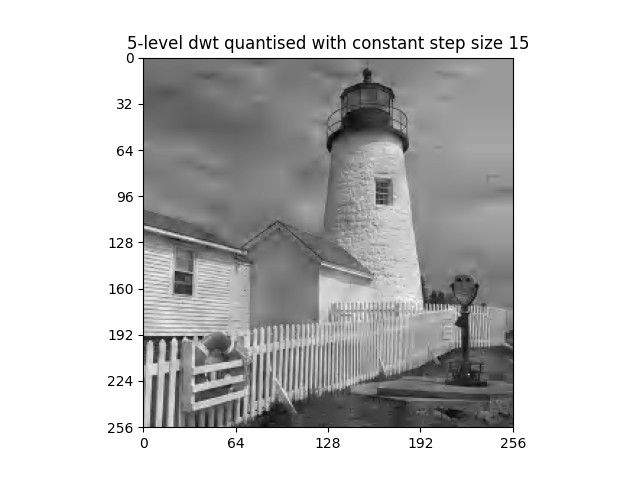

In [27]:
# your code here
N = 5
const_step_size = 15
dwtstep = np.ones((3, N+1)) * const_step_size

Y = nlevdwt(X, N)
Yq, dwtent = quantdwt(Y, dwtstep)
Z = nlevidwt(Yq, N)

fig, ax = plt.subplots()
plot_image(Z)
ax.set_title(f"{N}-level dwt quantised with constant step size {const_step_size}");

All of our experiments thus far have been performed on only one image. At this stage it is worth starting to experiment with the additional `Bridge` image, as well as Lighthouse. Bridge contains a lot more fine detail and may not lead to the same conclusions regarding performance.

In [28]:
Xb, _ = load_mat_img(img='bridge.mat', img_info='X', cmap_info={'map'})
Xb = Xb - 128.0

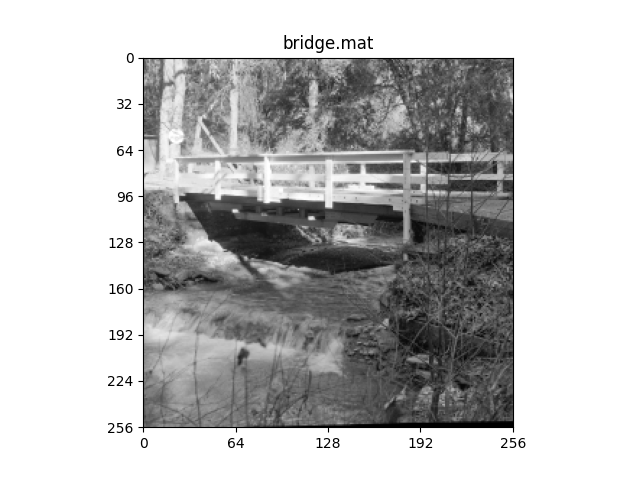

In [29]:
fig, ax = plt.subplots()
plot_image(Xb, ax=ax)
ax.set(title="bridge.mat");


<div class="alert alert-block alert-danger">

Investigate the performance of
both an equal-step-size and an equal-MSE scheme (follow a similar procedure as you used for the Laplacian Pyramid to find the appropriate step-size ratios). Hence determine how many levels of DWT are reasonably optimal for the Lighthouse and Bridge images. Also evaluate the subjective quality of your reconstructed images, and comment on how this depends on $n$ and on the way that step-sizes are assigned
to the different levels. Once again, for each image choose quantisation steps such that you match the rms error to that for direct quantisation with a step-size of 17.</div>

In [30]:
# your code here

# find the step-size ratios for the equal-MSE scheme
def generateImpulseImage(impulseMagnitude, layer, location, shape=(256,256)):
    """Create a blank image with an impulse of given magnitude at the centre of a specified sub-image.

    Parameters
    - impulseMagnitude: magnitude of the impulse to be inserted
    - layer: layer of the dwt in which to insert the sub-image (starting at layer 0)
    - location: {0,1,2,3} represent top-right, bottom-left, bottom-right and top-left sub-images
    of a given layer respectively. Note that top-left (3) should only be used for the final layer
    - shape: shape of the image, defaults to a 256x256 image

    Returns
    - image containing the impulse at specified location and zeros elsewhere
    """
    if location not in {0,1,2,3}:
        raise ValueError("Location must be one of {0,1,2,3} for top-right, bottom-left, bottom-right, top-left respectively.")
    
    blank_image = np.zeros(shape)
    height, width = shape
    for _ in range(layer + 1):
        height = height//2
        width = width//2

    starting_coords_dict = {0: (0, width), 1: (height, 0), 2: (height, width), 3: (0, 0)}
    (start_height, start_width) = starting_coords_dict[location]

    blank_image[start_height + height//2][start_width + width//2] += impulseMagnitude
    return blank_image


In [31]:
for dwtlayers in range(1,6):
    print(f"{dwtlayers}-layer dwt:")
    dwtstepratios = np.zeros((3, dwtlayers+1))

    for i in range(dwtlayers):
        for k in range(3):
            impulseImg = generateImpulseImage(100, i, k)
            reconstructed = nlevidwt(impulseImg, dwtlayers)
            reconstructed_energy = np.sum(reconstructed**2.0)
            dwtstepratios[k, i] = 1 / np.sqrt(reconstructed_energy)
    impulseImg = generateImpulseImage(100, dwtlayers-1, 3)
    reconstructed = nlevidwt(impulseImg, dwtlayers)
    reconstructed_energy = np.sum(reconstructed**2.0)
    dwtstepratios[0, dwtlayers] = 1 / np.sqrt(reconstructed_energy)

    dwtstepratios = dwtstepratios / np.max(dwtstepratios)
    print("Normalised step size ratios matrix:")
    print(dwtstepratios)


1-layer dwt:
Normalised step size ratios matrix:
[[0.72231512 1.        ]
 [0.72231512 0.        ]
 [0.52173913 0.        ]]
2-layer dwt:
Normalised step size ratios matrix:
[[1.         0.65212702 0.75514762]
 [1.         0.65212702 0.        ]
 [0.72231512 0.56316094 0.        ]]
3-layer dwt:
Normalised step size ratios matrix:
[[1.         0.65212702 0.35563319 0.3863546 ]
 [1.         0.65212702 0.35563319 0.        ]
 [0.72231512 0.56316094 0.32735463 0.        ]]
4-layer dwt:
Normalised step size ratios matrix:
[[1.         0.65212702 0.35563319 0.18207392 0.19430699]
 [1.         0.65212702 0.35563319 0.18207392 0.        ]
 [0.72231512 0.56316094 0.32735463 0.17061102 0.        ]]
5-layer dwt:
Normalised step size ratios matrix:
[[1.         0.65212702 0.35563319 0.18207392 0.09158986 0.09729574]
 [1.         0.65212702 0.35563319 0.18207392 0.09158986 0.        ]
 [0.72231512 0.56316094 0.32735463 0.17061102 0.08621861 0.        ]]


In [32]:
def getdwtstepratios(dwtlayers, printStuff=True):
    locations_dict = {0: "   top-right", 1: " bottom-left", 2: "bottom-right"}
    dwtstepratios = np.zeros((3, dwtlayers+1))

    for i in range(dwtlayers):
        for k in range(3):
            impulseImg = generateImpulseImage(100, i, k)
            reconstructed = nlevidwt(impulseImg, dwtlayers)
            reconstructed_energy = np.sum(reconstructed**2.0)

            if printStuff:
                print(f"Impulse in {locations_dict[k]} sub-image of layer {i} in the {dwtlayers}-layer dwt leads to energy {reconstructed_energy} of reconstructed image.")
            dwtstepratios[k, i] = 1 / np.sqrt(reconstructed_energy)

    impulseImg = generateImpulseImage(100, dwtlayers-1, 3)
    reconstructed = nlevidwt(impulseImg, dwtlayers)
    reconstructed_energy = np.sum(reconstructed**2.0)
    dwtstepratios[0, dwtlayers] = 1 / np.sqrt(reconstructed_energy)
    if printStuff:
        print(f"Impulse in top-left sub-image of final layer in the {dwtlayers}-layer dwt leads to energy {reconstructed_energy} of reconstructed image.")

    dwtstepratios = dwtstepratios / np.max(dwtstepratios)
    if printStuff:
        print("Normalised step size ratios matrix:")
        print(dwtstepratios)
    return dwtstepratios


In [33]:
x = getdwtstepratios(4)

Impulse in    top-right sub-image of layer 0 in the 4-layer dwt leads to energy 43125.0 of reconstructed image.
Impulse in  bottom-left sub-image of layer 0 in the 4-layer dwt leads to energy 43125.0 of reconstructed image.
Impulse in bottom-right sub-image of layer 0 in the 4-layer dwt leads to energy 82656.25 of reconstructed image.
Impulse in    top-right sub-image of layer 1 in the 4-layer dwt leads to energy 101406.25 of reconstructed image.
Impulse in  bottom-left sub-image of layer 1 in the 4-layer dwt leads to energy 101406.25 of reconstructed image.
Impulse in bottom-right sub-image of layer 1 in the 4-layer dwt leads to energy 135976.5625 of reconstructed image.
Impulse in    top-right sub-image of layer 2 in the 4-layer dwt leads to energy 340976.5625 of reconstructed image.
Impulse in  bottom-left sub-image of layer 2 in the 4-layer dwt leads to energy 340976.5625 of reconstructed image.
Impulse in bottom-right sub-image of layer 2 in the 4-layer dwt leads to energy 402431.

In [54]:
# Find the quantisation step size for equal mse, matching the reference RMS error
reference_rms = np.std(X - quantise(X, 17))
reference_bits = bpp(quantise(X, 17)) * X.size

def calculate_mse_rms(step_size_matrix, num_layers):
    Y = nlevdwt(X, num_layers)
    Yq, _ = quantdwt(Y, step_size_matrix)
    Z = nlevidwt(Yq, num_layers)
    return np.std(X - Z)

def optimise_mse_steps(num_layers, possible_starting_step_sizes, reference_error=reference_rms):
    dwtstepratios = getdwtstepratios(num_layers, printStuff=False)
    min_error, best_step_size = 1e9, -1
    for k in possible_starting_step_sizes:
        dwtstep = dwtstepratios * k
        error = np.abs(calculate_mse_rms(dwtstep, num_layers) - reference_error)
        if error < min_error:
            min_error, best_step_size = error, k
    print("best step size =", best_step_size, "with error", min_error)
    dwtstep = dwtstepratios * best_step_size
    return dwtstep

In [58]:
hi = {1: 'a', 2: 'b'}
for key, val in hi.items():
    print(key, "!", val)

1 ! a
2 ! b


In [59]:
possible_step_sizes = [i for i in range(1,30)]  # initial rough optimisation
for num_dwt_layers in range(1, 6):
    print("num layers =", num_dwt_layers)
    dwtstep = optimise_mse_steps(num_dwt_layers, possible_step_sizes)

num layers = 1
best step size = 15 with error 0.02412904587623821
num layers = 2
best step size = 11 with error 0.03308917848267878
num layers = 3
best step size = 11 with error 0.06181831915075087
num layers = 4
best step size = 11 with error 0.16452670362647837
num layers = 5
best step size = 10 with error 0.1315980834536914


In [64]:
# using previous results, we can narrow the searches to higher precision
layers_and_step_ranges = {1: [i/100 for i in range(1480, 1500)],
                          2: [i/100 for i in range(1070, 1090)],
                          3: [i/100 for i in range(1030, 1090)],
                          4: [i/100 for i in range(1020, 1080)],
                          5: [i/100 for i in range(1020, 1040)]
                          }

reconstructed_images = []

for num_dwt_layers, possible_step_sizes in layers_and_step_ranges.items():
    print(f"{num_dwt_layers} layers:")
    dwtstep = optimise_mse_steps(num_dwt_layers, possible_step_sizes)
    Y = nlevdwt(X, num_dwt_layers)
    Yq, dwtent = quantdwt(Y, dwtstep)
    dwt_bits = np.sum(dwtent)
    compression_ratio = reference_bits / dwt_bits
    print("compression ratio", compression_ratio)
    
    reconstructed_images.append(nlevidwt(Yq, num_dwt_layers))



1 layers:
best step size = 14.93 with error 0.001206696573861521
compression ratio 2.131176039488239
2 layers:
best step size = 10.87 with error 0.00012941227877227846
compression ratio 2.8334114565738955
3 layers:
best step size = 10.8 with error 0.0003595372455285073
compression ratio 3.148476925688737
4 layers:
best step size = 10.53 with error 0.0012242661152974676
compression ratio 3.205736147033042
5 layers:
best step size = 10.36 with error 0.00034997936359459914
compression ratio 3.2017026719517827


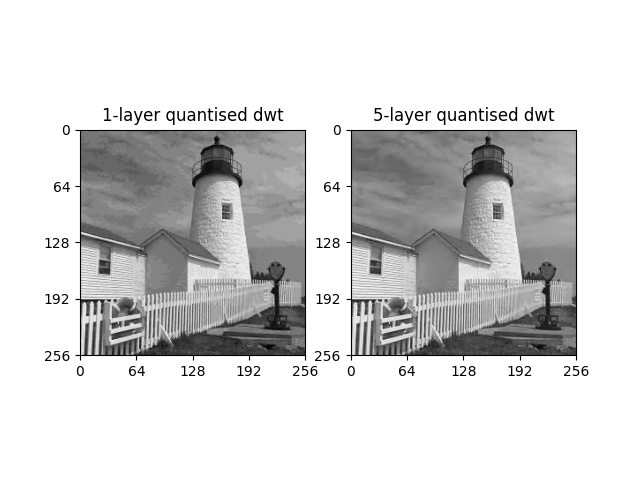

In [65]:
fig, ax = plt.subplots(1,2)
plot_image(reconstructed_images[0], ax=ax[0])
ax[0].set_title("1-layer quantised dwt")
plot_image(reconstructed_images[4], ax=ax[1])
ax[1].set_title("5-layer quantised dwt");

In [66]:
# TODO: equal-step-size scheme 
# TODO: repeat for Bridge image
# TODO: Hence determine how many levels of DWT are reasonably optimal for the Lighthouse and Bridge images. 
# TODO: Also evaluate the subjective quality of your reconstructed images
# TODO: comment on how this depends on n and on the way that step-sizes are assigned to the different levels. 

## 9.4 Second Interim Report

This report should include the new results from the DCT, LBT and DWT energy
compaction methods in a format that will allow them to be compared with each other and contrasted to the
Laplacian pyramid work in your first report.  Again try to answer questions
raised in the text, and also include discussion of any topics that have led to
unexpected results or have proved particularly interesting.